# Across-State-Visits Testing with [GLHMM toolbox](https://github.com/vidaurre/glhmm)
This tutorial explains how to use the [GLHMM toolbox](https://github.com/vidaurre/glhmm), part of the paper [The Gaussian-Linear Hidden Markov Model: a Python Package](https://arxiv.org/abs/2312.07151), to explore whether brain states identified by a Hidden Markov Model (HMM) are related to a continuous signal, like a behavioral measurement.

For simplicity, we use synthetic data instead of real data. The brain data ($D$) comes from the Viterbi path, which represents the sequence of brain states identified by the HMM. These states capture patterns in brain activity over time. The behavioral data ($R$) is a continuous signal recorded at the same time as the brain data. 

The purpose of the test is to determine if the brain states decoded by the HMM are associated with patterns in the behavioral signal. While data preparation requires some explanation, running the ```test_across_state_visits``` function is straightforward. Simply provide the input variables ($D$ and $R$) and specify the method for the analysis.


**Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/Testing_across_visits.ipynb).

Authors: Nick Yao Larsen <nylarsen@cfin.au.dk>

## Table of Contents
1. [Load and prepare data](#load-data)
2. [Permutation testing tutorial - Across-Visits](#perm-intro)
    * [Multivariate](#perm-regression)
    * [Univariate](#perm-correlation)
    * [One-state-vs-the-rest (OSR)](#perm-rest)
    * [One-state-vs-another-state (OSA)](#perm-pairs)

### Install necessary packages
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install git+https://github.com/vidaurre/glhmm```

### Import libraries
Let's start by importing the required libraries and modules.

In [1]:
# Importing libraries
import numpy as np
from pathlib import Path
from glhmm import glhmm, graphics, statistics

## 1.Load and prepare data <a id="load-data"></a>

Example data is available in the folder [data_statistical_testing](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing). The file ```vpath.npy``` contains the Viterbi path, and ```sig_data.npy``` is synthetic timeseries.

The Viterbi path, derived from synthetic brain data, was decoded using a Hidden Markov Model (HMM). Detailed training steps for the HMM model can be found in this [tutorial](./GaussianHMM_example.ipynb).\
To generate the Viterbi path yourself, use the following code after training the model:

```python
vpath = hmm.decode(X=None, Y=D_data, indices=idx, viterbi=True)
```

For this example, the Viterbi path is precomputed to focus on statistical analysis between the brain data ($D$) and synthetic timeseries ($R$).

We will now load the data.

In [2]:
# Get the current directory
PATH_PARENT = Path.cwd()
# Path of the location of the data
PATH_DATA = PATH_PARENT / "data_statistical_testing"

# Load vpath (D)
vpath = np.load(PATH_DATA/"vpath.npy")

# Load sig_data (R)
sig_data = np.load(PATH_DATA/"sig_data.npy")

print(f"Data dimension of vpath: {vpath.shape}")
print(f"Data dimension of sig_data: {sig_data.shape}")

Data dimension of vpath: (5000, 5)
Data dimension of sig_data: (5000, 1)


### Look at data <a id="look-data"></a>
Now we can look at the data structure.
- vpath: 2D array of shape (n_timepoints, n_states)
- sig_data: 1D array of shape (n_timepoints,)

```vpath``` has 5000 rows and 5 columns. Each row represents a moment in time, and the columns show which brain state the HMM identified at that moment.

```sig_data``` has 5000 rows and 1 column. Each row contains the value of a continuous signal measured at the same time as the brain data.


### Visualize Viterbi path
Now, let's visualize the distinct states in the Viterbi path from our trained Hidden Markov Model.

The plot provides a clear depiction of each time point assigned to a specific HMM state, with each state represented by a distinct color. This visualization allows us to easily discern the temporal distribution and transitions between different states.

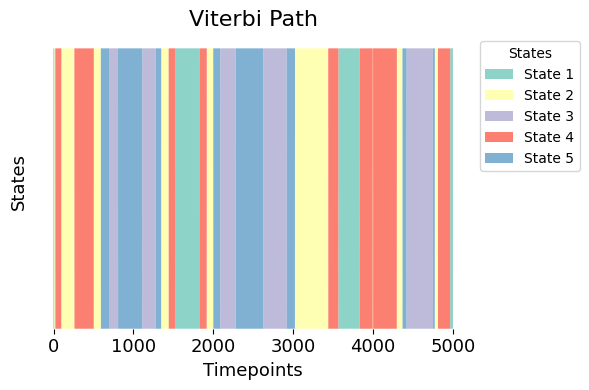

In [3]:
graphics.plot_vpath(vpath, figsize=(6,4), ylabel="States")

**Plot Viterbi path and discrete states**\
This plot shows the brain states identified by the HMM over time, with each state represented by a different color. It makes it easy to see which state the model assigned to each moment.

At the top of the plot, there’s an extra layer that shows the state assignments as numbers on the y-axis. For example, if you see the number 5 on the y-axis in blue, it means the data at that moment belongs to state 5. This format is similar to Figure 3D in our paper.

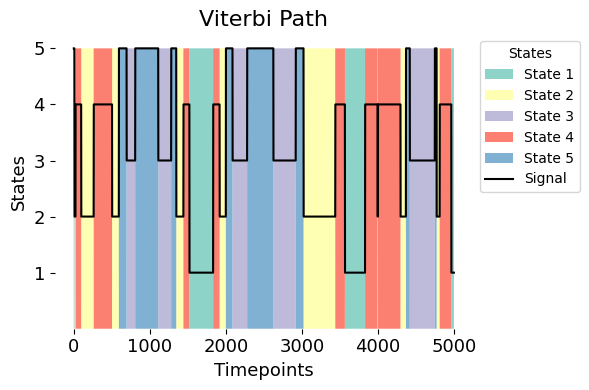

In [4]:
# Create a 1D array from the one-hot encoded Viterbi path data
vpath_1D=statistics.generate_vpath_1D(vpath)
# Convert the signal to be in a range from 0 to 1,
sig_state = vpath_1D/np.max(vpath_1D)
# Plot discrete states with the Viterbi path
graphics.plot_vpath(vpath,sig_state, figsize=(6,4), ylabel="States", yticks=True)

**Plot Viterbi path and signal**\
This plot shows the Viterbi path (D) together with the signal (R). Each time point is color-coded based on the brain state assigned by the HMM, making it easy to compare the signal and the state changes.

To create this plot, the signal data is adjusted to fit on the same scale as the Viterbi path (from 0 to 1). This adjustment is just for visualization, helping us overlay the two and see how well the model reflects the patterns in the signal.

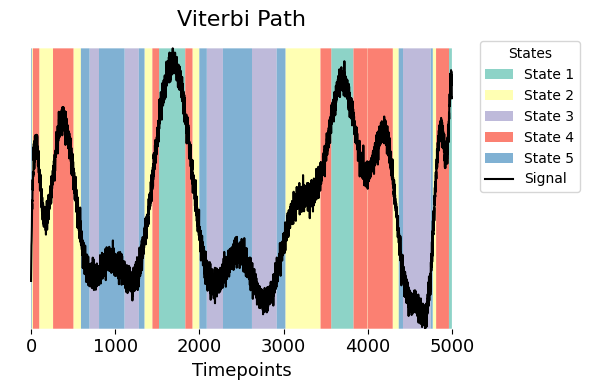

In [5]:
# Normalize the sig_data to the range [0, 1]
min_value = np.min(sig_data)
max_value = np.max(sig_data)
normalized_sig_data = ((sig_data - min_value) / (max_value - min_value))

# Plot vpath and sig_data
graphics.plot_vpath(vpath,normalized_sig_data, figsize=(6,4))

Let's delve into the values assigned to each state. To achieve this, we calculate the average of the values associated with each state.

This brief analysis provides insights into the typical or central values characterizing each state. By examining these averages, we gain a clearer understanding of the distinctive characteristics and patterns represented by the different states in our HMM.



In [6]:
vpath_1D=statistics.generate_vpath_1D(vpath)
val_state =[np.mean(sig_data[vpath_1D == i+1]) for i in range(vpath.shape[1]) ]
val_state

[4.912042797300882,
 -0.05858422375450776,
 -3.795696791047377,
 2.352225972831181,
 -2.5030418147224505]

The above figure shows an relation between the simulated measurements (```sig_data```) and the Viterbi path (```vpath```). Notably, a closer examination of the variable ```val_state``` shows distinct values assigned to each specific state: 

* State 1 (green) aligns with highest value 
* State 2 (yellow) corresponds to values in the middle, close to 0. 
* State 3 (purple) corresponds to the lowest negative values.
* States 4 (red) and State 5 (blue) are values that fall between the extremes values. 
This gives us a perspective on the behavioral dynamics across different states on our signal.

## 2. Permutation testing tutorial - Across-Visits <a id="perm-intro"></a>
As we move on to the next part of this tutorial, let's dive into how we can use the ```test_across_state_visits``` function.
This function helps us to find connections between HMM state time course (D) and behavioral variables or individual traits (R) using permutation testing.


**Permutation testing**\
Permutation testing does not assume any particular data distribution and the procedure shuffles the data around to create a null distribution. This null distribution comes in handy for testing our hypotheses without making any assumptions about the data.
This null distribution becomes our benchmark to test the question: is there any real difference or relationship between the variables we're interested in?

### Across visits - Multivariate <a id="perm-regression"></a>

The multivariate analysis aims to determine how the Viterbi path (```D_data```), characterized by different states, contributes to explaining the observed variability in the simulated signal (```R_data```). By quantifying explained variance, this analysis evaluates whether state transitions significantly influence changes in signal values over time.

A permutation test for explained variance assesses the statistical significance of this relationship. A significant result indicates that the Viterbi path meaningfully explains the signal's variability, while a non-significant result suggests the observed relationship is likely due to random chance.

To run the test, use the across_state_visits function by providing the inputs:

**Inputs**:

* ```D_data```: The Viterbi path.
* ```R_data```: The simulated signal.

**Settings**:

* ```method = "multivariate"```: Specifies that the test should perform multivariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).

For details on additional settings, refer to the function documentation.

In [45]:
from importlib import reload
reload(statistics)
# Set the parameters for across_visits testing
method = "multivariate"
Nperm = 1000 # Number of permutations (default = 1000)
result_multivariate  =statistics.test_across_state_visits(vpath, 
                                                          sig_data, 
                                                          method=method,
                                                          Nperm=Nperm)

100%|██████████| 1000/1000 [00:13<00:00, 73.12it/s]


We can now examine the local ```result_multivariate``` variable.

In [46]:
result_multivariate

{'pval': array(0.000999),
 'base_statistics': array(0.95321453),
 'test_statistics': array([ 9.53214525e-01, -1.24241878e-01, -8.87320782e-01, -1.68214979e+00,
        -1.41126131e+00, -6.01767791e-01, -4.39853762e-01, -1.08939551e+00,
        -6.83688332e-01, -7.89151955e-01, -9.36770821e-01, -1.29928917e+00,
        -6.56578793e-01, -1.30516079e+00, -1.31212891e+00, -4.11809328e-01,
        -1.01893648e+00, -1.45531543e+00, -5.01463283e-01, -8.44632462e-01,
        -3.76048720e-01,  3.61063543e-02, -7.46286507e-01, -1.82222686e-01,
        -1.51423803e+00, -5.74070775e-01, -1.01505921e+00, -1.25622444e+00,
        -2.15396057e+00, -1.09548303e+00, -1.21804189e+00, -6.35414262e-01,
        -6.31180940e-01, -5.70793787e-01, -3.56441907e-01, -3.65559760e-01,
        -1.12149760e+00, -1.74112989e+00, -1.34328946e+00, -5.99536047e-01,
        -8.68585621e-01, -9.24215863e-01,  3.26438604e-02, -1.33348428e+00,
        -8.88371178e-01, -8.03288249e-01, -2.94534643e-01, -8.48588210e-01,
    

What we can see here is that ```result_multivariate``` is a dictionary containing the outcomes of a statistical analysis conducted using the specified ```method``` and ```test_type```. 

Let us break it down:
* ```pval```: This array holds the p-values resulting from the permutation test. Each value corresponds to a behavioral variable and will have shape of 1 by q, see [GLHMM paper](https://arxiv.org/abs/2312.07151).

* ```base_statistics```: Stores the base statistics of the tests. In this case it is the explained variance $R^2$

* ```test_statistic```: Will by default always return a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```statistical_measures```: A dictionary that marks the units used as test_statistics

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_visits```.

* ```method```: Specifies the analytical method employed, which is ```'multivariate'```, which means that the analysis is carried out using regression-based permutation testing.

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```Nperm```: Is the number of permutations that has been performed.

* ```test_summary```: A dictionary summarizing the test results based on the applied method.

**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will import the function ```plot_p_values_bar``` from module ```graphics.py```

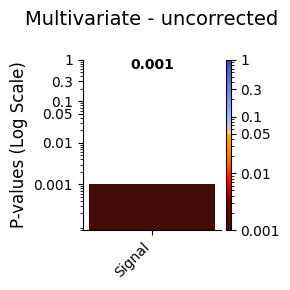

In [47]:
# Plot p-values
graphics.plot_p_values_bar(result_multivariate["pval"], 
                           title_text ="Multivariate - uncorrected",
                           figsize=(3, 3), 
                           alpha=0.05, 
                           xticklabels=["Signal"])

#### Conclusion - Multivariate
The multivariate test between the Viterbi path and the signal resulted in a statistically significant p-value. This indicates a meaningful relationship between the brain states identified by the HMM and the signal, suggesting that the states capture important dynamics related to the observed data.

### Across visits - Univariate test <a id="perm-correlation"></a>

The univariate analysis evaluates pairwise relationships between discrete states in the Viterbi path (```D_data```) and the variability in the signal (```R_data```). Each state is tested individually against the signal, resulting in one p-value per state. For example, with 5 states and 1 signal, the test will produce 5 p-values.

The goal is to assess whether specific states in the Viterbi path significantly contribute to changes in the signal values over time. A permutation test determines the statistical significance of these relationships:

To run the test, we set the following parameters:

**Inputs**:

* ```D_data```: The Viterbi path.
* ```R_data```: The simulated signal.

**Settings**:

* ```method = "univariate"```: Specifies that the test should perform multivariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).

The function ```test_across_state_visits``` is used as follows:


In [48]:
# Set the parameters for across_visits testing
method = "univariate"
Nperm = 1000
result_univariate  =statistics.test_across_state_visits(vpath, 
                                                        sig_data, 
                                                        method=method,
                                                        Nperm=Nperm)

100%|██████████| 1000/1000 [00:14<00:00, 71.17it/s]


We can now examine the local ```result_univariate``` variable.

In [49]:
result_univariate

{'pval': array([0.000999  , 0.8971029 , 0.001998  , 0.00899101, 0.04995005]),
 'base_statistics': array([ 0.63053061,  0.02544851, -0.62533888,  0.48084955, -0.39815568]),
 'test_statistics': array([[0.63053061, 0.02544851, 0.62533888, 0.48084955, 0.39815568],
        [0.00071007, 0.10616043, 0.01726642, 0.14104981, 0.16664687],
        [0.17171311, 0.05783198, 0.20129367, 0.0119556 , 0.03170386],
        ...,
        [0.11814931, 0.18447228, 0.15639604, 0.42893204, 0.0698071 ],
        [0.0625029 , 0.05526369, 0.0310165 , 0.29777624, 0.21249453],
        [0.26139098, 0.30837295, 0.2578407 , 0.35893434, 0.18179713]]),
 'statistical_measures': {'corr_coef_cols': 'all_columns'},
 'test_type': 'test_across_state_visits',
 'method': 'univariate',
 'max_correction': False,
 'Nperm': 1000,
 'test_summary': {'Predictor': array(['State 1', 'State 2', 'State 3', 'State 4', 'State 5'], dtype='<U7'),
  'Outcome': array(['Regressor 1', 'Regressor 1', 'Regressor 1', 'Regressor 1',
         'Regress

Now that we have the permutation distribution ['test_statistic] as we can see, it is because we set ```test_statistic_option=True```

**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.
We will import the function ```plot_heatmap```, ```plot_scatter_with_labels``` and ```plot_histograms``` from module ```helperfunctions.py```

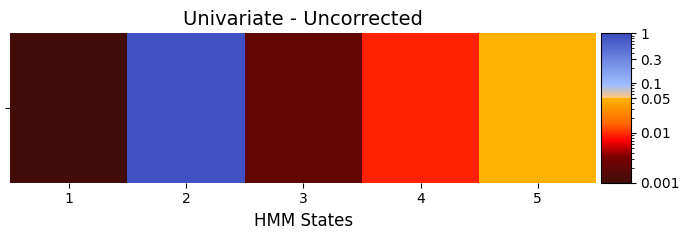

In [50]:
# Plot p-values
graphics.plot_p_value_matrix(result_univariate["pval"].T, 
                             title_text ="Univariate - Uncorrected",
                             figsize=(7, 2.5), 
                             xlabel="HMM States", 
                             alpha=0.05, 
                             x_tick_min=1)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

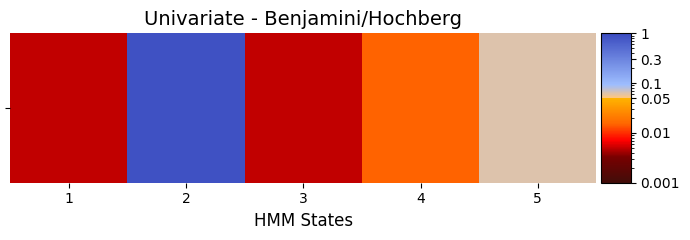

In [51]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_univariate, 
                                                               method='fdr_bh')
# Plot p-values
graphics.plot_p_value_matrix(pval_corrected.T, title_text ="Univariate - Benjamini/Hochberg",
                             figsize=(7, 2.5), 
                             xlabel="HMM States", 
                             x_tick_min=1)

Instead of using a heatmap, we can also visualize the results with a bar plot

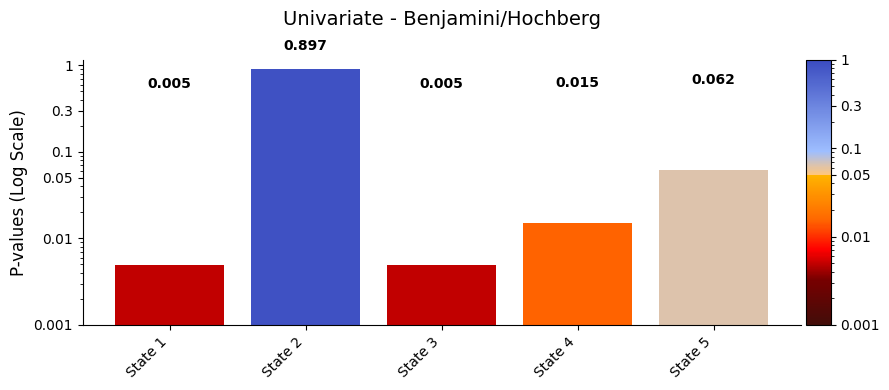

In [52]:
# Set the threshold of alpha to be 0.05
alpha = 0.05
variables = [f"State {i+1}" for i in range(len(pval_corrected))] # construct the variable names
graphics.plot_p_values_bar(pval_corrected,
                           alpha = alpha, 
                           xticklabels=variables, 
                           title_text="Univariate - Benjamini/Hochberg")

**Plot permutation distribution**\
Presented here are the test statistics(```result["test_statistic"]```) of our permutation distributions for different states.\
The red line shows the observed statistic, while the datapoints of the histogram represent the permutation distribution

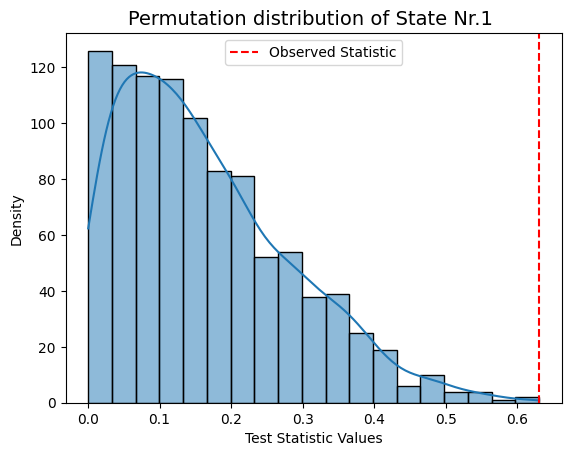

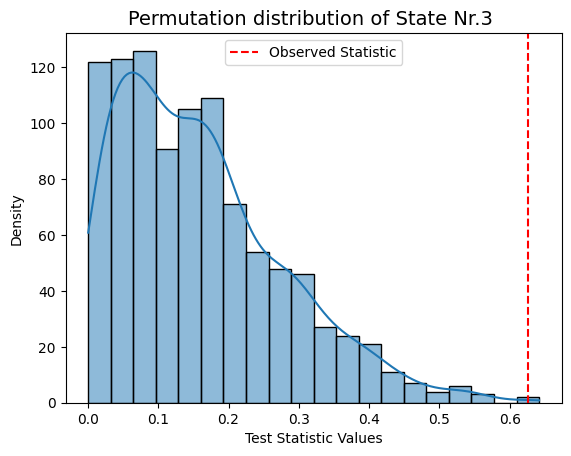

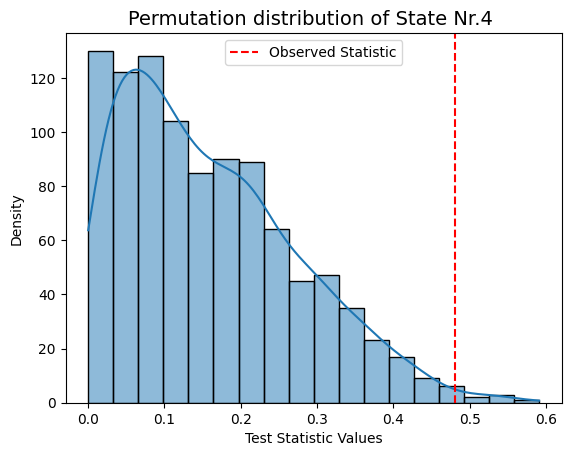

In [53]:
# Plot test statistics for pvals
significant_timestamp_position = np.where(pval_corrected < alpha)
for i in significant_timestamp_position[0]:
    graphics.plot_permutation_distribution(result_univariate["test_statistics"][:,i],
                                           title_text=f"Permutation distribution of State Nr.{i+1} ")

#### Conclusion - Univariate
The results show that states 1, 3, and 4 have a significant relationship with the signal, while states 2 and 5 do not. The signal's highest peak aligns with state 1, the lowest with state 3, and the second-highest with state 4, supporting these findings.

This suggests that states with extreme signal values have a stronger influence on the signal's changes, while states 2 and 5 may have a weaker or less clear impact.


## Across visits -  One-state-vs-the-rest (OSR) <a id="perm-rest"></a>
The OSR test assesses whether a specific state in the Viterbi path (`D_data`) significantly differs from the combined influence of all other states on the signal (`R_data`). This test generates five p-values, one for each state.

By default, the test checks if a state is larger than the rest using `state_com='larger'`. To test if a state is smaller, set `state_com='smaller'`.

**Inputs**:

* ```D_data```: The Viterbi path.
* ```R_data```: The simulated signal.

**Settings**:

* ```method = "ors"```: Specifies that the test should perform multivariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).


In [54]:
# Set the parameters for across_visits testing
method = "osr"
Nperm = 1000
test_statistics_option=True

result_one_vs_rest  =statistics.test_across_state_visits(vpath, 
                                                         sig_data, 
                                                         method=method,
                                                         Nperm=Nperm, 
                                                         test_statistics_option=test_statistics_option)

100%|██████████| 1000/1000 [00:13<00:00, 76.31it/s]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.
We will plot the p-values using the function ```plot_p_value_matrix```

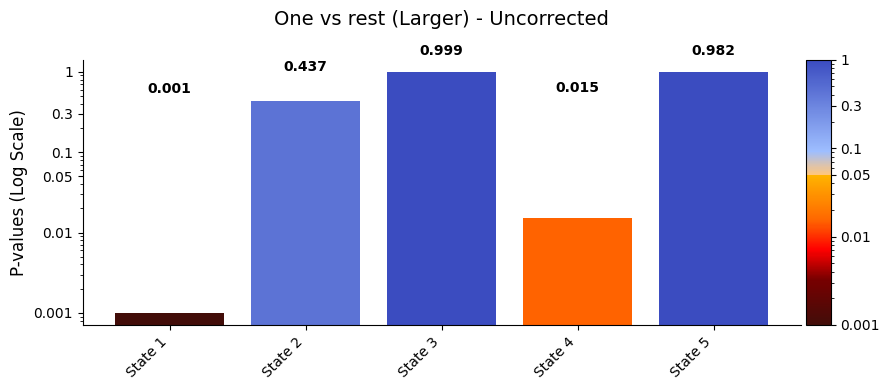

In [55]:
# Set the threshold of alpha to be 0.05
alpha = 0.05
variables = [f"State {i+1}" for i in range(len(result_one_vs_rest["pval"]))] # construct the variable names
title_text = "One vs rest (Larger) - Uncorrected"
graphics.plot_p_values_bar(result_one_vs_rest["pval"],
                           alpha = alpha, 
                           xticklabels=variables, 
                           title_text=title_text)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

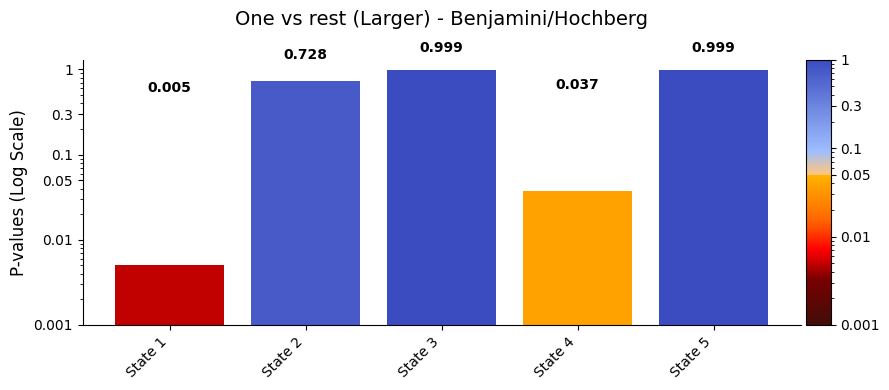

In [56]:
pval_corrected, _ =statistics.pval_correction(result_one_vs_rest, 
                                              method='fdr_bh')
# Plot p-values
graphics.plot_p_values_bar(pval_corrected,alpha = alpha, 
                           xticklabels=variables, 
                           title_text="One vs rest (Larger) - Benjamini/Hochberg")


In [57]:
val_state

[4.912042797300882,
 -0.05858422375450776,
 -3.795696791047377,
 2.352225972831181,
 -2.5030418147224505]

#### Conclusion - One vs rest
After applying the Benjamini/Hochberg method to control the False Discovery Rate (FDR), the adjusted p-values for the one vs. rest test are:

* State 1: 0.005 
* State 2: 0.718  
* State 3: 1 
* State 4: 0.047
* State 5: 1

States 1 and 4, which have the lowest adjusted p-values, correspond to the highest values in `sig_data`. A significant p-value in the one vs. rest test indicates that the mean signal for a specific state is significantly different from the combined influence of all other states.

## Across visits - One-state-vs-another-state (OSA) <a id="perm-pairs"></a>
The OSA test compares the mean signal differences between pairs of states (e.g., state 1 vs. state 2, state 1 vs. state 3, etc.). This test evaluates whether the observed mean difference between specific state pairs is statistically significant.


**Inputs**:

* ```D_data```: The Viterbi path.
* ```R_data```: The simulated signal.

**Settings**:

* ```method = "osa"```: Specifies that the test should perform multivariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).

In [58]:
# Set the parameters for across_visits testing
method = "osa"
Nperm = 1000
test_statistics_option=True

result_state_pairs  =statistics.test_across_state_visits(vpath, 
                                                         sig_data, 
                                                         method=method,
                                                         Nperm=Nperm,
                                                         test_statistics_option=test_statistics_option)

Pairwise comparisons: 100%|██████████| 10/10 [02:03<00:00, 12.37s/it]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.
We will plot the p-values using the function ```plot_heatmap```. Notably, in this instance, we designate the values on the diagonal as NaN (Not a Number) since these values are expected to be zeros and can be safely ignored in the visualization.

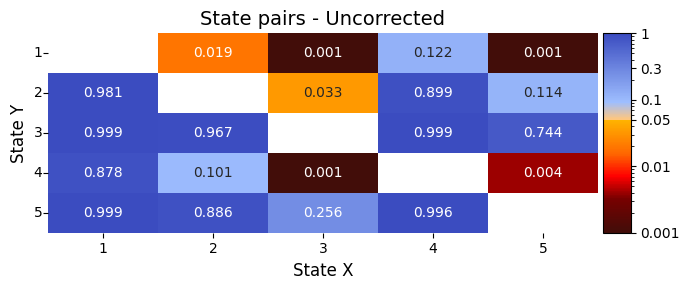

In [59]:
# Plot p-values# Plot p-values
graphics.plot_p_value_matrix(result_state_pairs["pval"], 
                             title_text ="State pairs - Uncorrected",
                             figsize=(7, 3), 
                             xlabel="State X", 
                             ylabel="State Y", 
                             alpha=0.05, 
                             none_diagonal=True, 
                             annot=True,
                             x_tick_min=1)

**Interpret the p-value matrix**\
The matrix has a shape of (number of states by number of states), and the values below the diagonal (lower-left) represent comparisons where the lower state number is less than the higher state number. Values above the diagonal (upper-right) represent comparisons where the lower state number is greater than the higher state number.

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

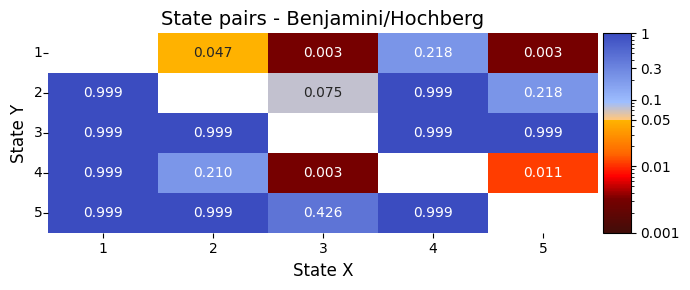

In [60]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_state_pairs, method='fdr_bh')
# Plot p-values# Plot p-values
graphics.plot_p_value_matrix(pval_corrected, 
                             title_text ="State pairs - Benjamini/Hochberg" ,
                             figsize=(7, 3), 
                             xlabel="State X", 
                             ylabel="State Y", 
                             alpha=0.05, 
                             none_diagonal=True, 
                             annot=True,
                             x_tick_min=1)

In [61]:
# Look at the val_sates values
val_state

[4.912042797300882,
 -0.05858422375450776,
 -3.795696791047377,
 2.352225972831181,
 -2.5030418147224505]

#### Conclusion - state pairs
The results show clear differences in the signal between certain pairs of brain states:

* **State 1** (the highest signal value) is significantly different from states 2, 3, and 5.
* **State 3** (the lowest signal value) is significantly different from states 1 and 4.
* **States 4 and 5**, which are in the middle, also show a clear difference from each other and from state 1.

These differences suggest that specific pairs of brain states are linked to noticeable changes in the signal. This could help us understand how the signal shifts during transitions between states, such as when studying responses to pain.
